<a href="https://colab.research.google.com/github/alexD1990/Deep_Neural_Network_Regression_MPG/blob/main/Deep_Neural_Network_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
%cd /content/drive/MyDrive/ML_models

/content/drive/MyDrive/ML_models


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.12.0


##The Auto MPG dataset

In [3]:
# Getting the dataset from UCI

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)


In [32]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


##Clean the dataset

In [33]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [34]:
# Dropping the na rows
dataset = dataset.dropna()

In [36]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [37]:
# Converting the Origin column to dummy variables

dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [38]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


## Split the data into training and test sets

In [39]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

##Inspect the data

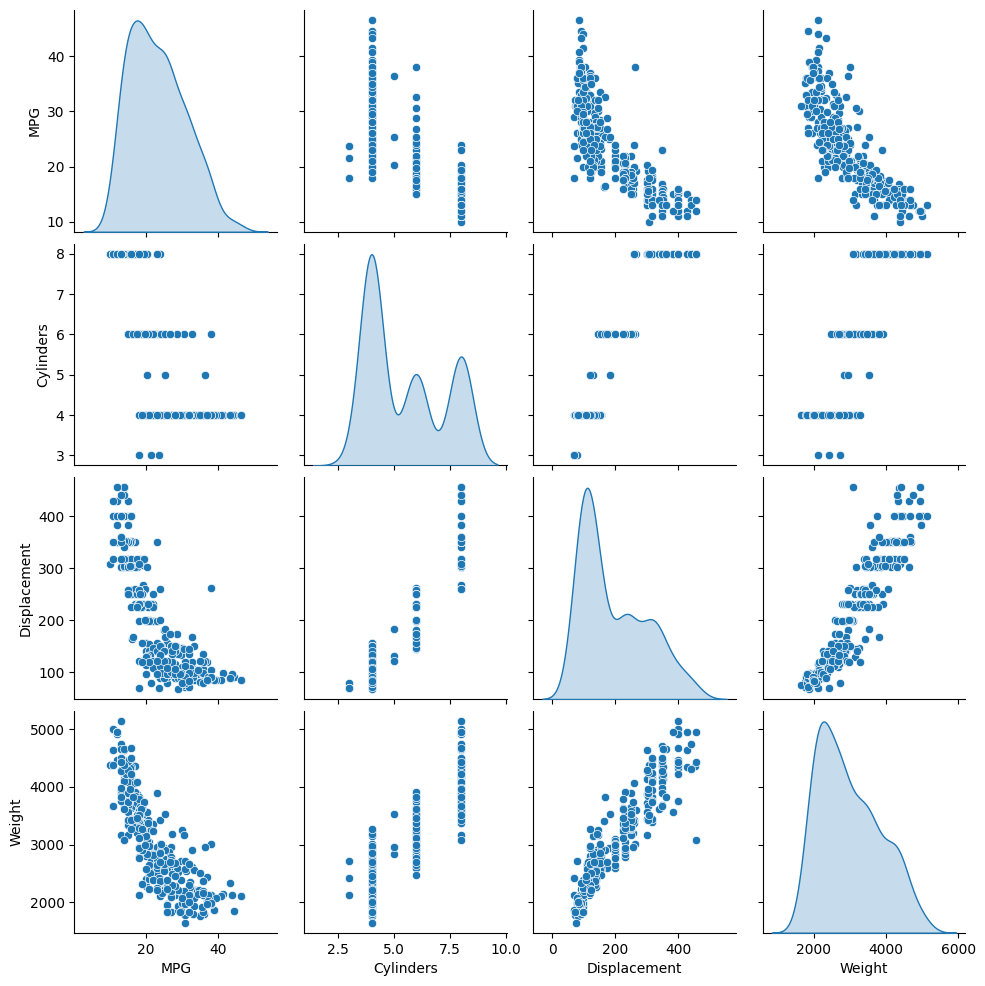

In [40]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde');

In [41]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


##Split features from labels

In [42]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

## Normalization

In [44]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [45]:
from keras.utils.np_utils import normalize
normalizer = tf.keras.layers.Normalization(axis=-1)

normalizer.adapt(np.array(train_features))

print(normalizer.mean.numpy())

[[5.47770691e+00 1.95318497e+02 1.04869446e+02 2.99025171e+03
  1.55592356e+01 7.58980942e+01 1.78343967e-01 1.97452217e-01
  6.24203861e-01]]


In [47]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


## Linear regression
Before building a neural network model, start with a linear regression using one and several variables

#Linear regression with one variable
Begin with a single-variable linear regression to predict `'MPG'` from `'Horsepower'`.

Training a model with `tf.keras` typically starts by defining the model architecture. Use a `tf.keras.Sequential` model, which represents a sequence of steps.

There are two steps in your single-variable linear regression model:

* Normalize the `'Horsepower'` input features using the `tf.keras.layers.Normalization` preprocessing layer.
* Apply a linear transformation to produce 1 output using a linear layer (`tf.keras.layers.Dense`).
The number of inputs can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

First, create a NumPy array made of the `'Horsepower'` features. Then, instantiate the `tf.keras.layers.Normalization` and fit its state to the `horsepower` data:

In [48]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

In [49]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [50]:
horsepower_model.predict(horsepower[:10])

1/1 [==============================] - 0s 105ms/step


array([[ 0.71219933],
       [ 0.40223068],
       [-1.3145187 ],
       [ 0.9983242 ],
       [ 0.9029492 ],
       [ 0.3545432 ],
       [ 1.0698555 ],
       [ 0.9029492 ],
       [ 0.2353245 ],
       [ 0.40223068]], dtype=float32)

In [53]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [54]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2
)

CPU times: user 5.59 s, sys: 186 ms, total: 5.78 s
Wall time: 11.2 s


In [55]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.806396,4.170208,95
96,3.803304,4.192508,96
97,3.803082,4.207943,97
98,3.808784,4.182553,98
99,3.805485,4.191193,99


In [56]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

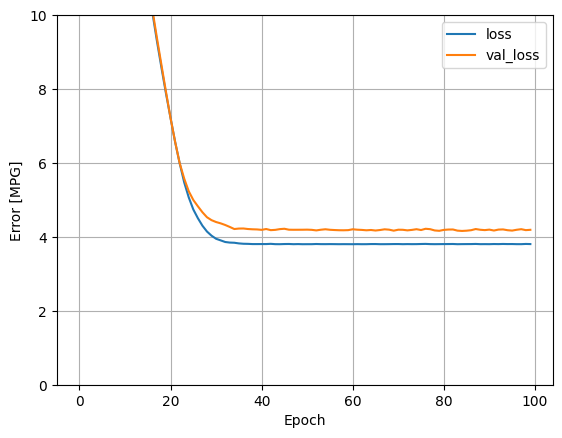

In [57]:
plot_loss(history)

In [58]:
# Collect the test results for later
test_results = {}

test_results['Horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0
)

In [59]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 [==============================] - 0s 5ms/step


In [60]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

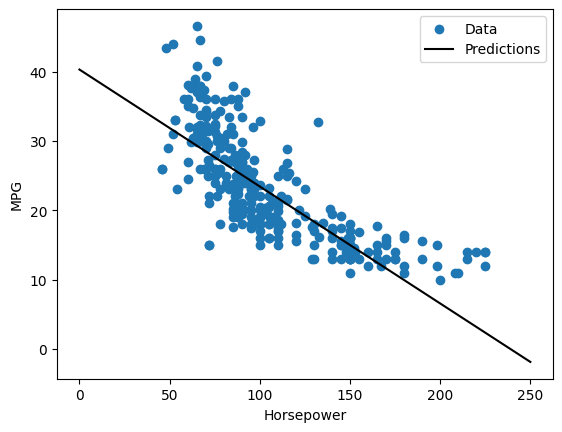

In [61]:
plot_horsepower(x, y)

#Linear regression with multiple inputs
You can use an almost identical setup to make predictions based on multiple inputs.

Create a two-step Keras Sequential model again with the first layer being `normalizer` (`tf.keras.layers.Normalization(axis=-1)`) you defined earlier and adapted to the whole dataset:

In [62]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [63]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 92ms/step


array([[ 1.2808467 ],
       [-0.17667484],
       [-3.8578634 ],
       [ 0.11185592],
       [ 3.1695676 ],
       [-1.3477145 ],
       [ 3.503918  ],
       [ 2.7430184 ],
       [-0.6248005 ],
       [ 3.9853075 ]], dtype=float32)

In [64]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.6024439 ],
       [-0.4492581 ],
       [-0.6610957 ],
       [-0.49128845],
       [ 0.26097727],
       [-0.6108412 ],
       [ 0.4474529 ],
       [ 0.4362532 ],
       [-0.66175014]], dtype=float32)>

In [65]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [67]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2
)

CPU times: user 5.43 s, sys: 160 ms, total: 5.59 s
Wall time: 11.1 s


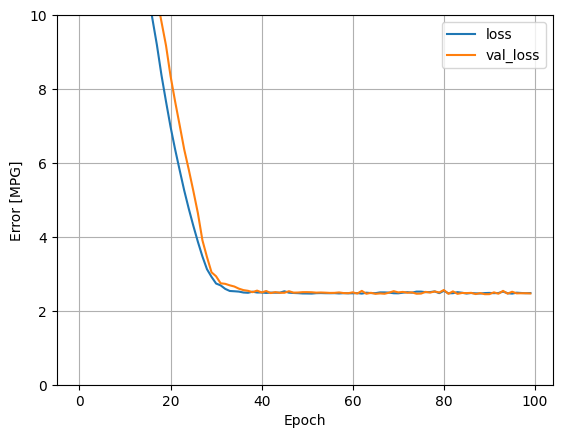

In [68]:
plot_loss(history)

In [69]:
# Collect the results for later

test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0
)

##Regression with a deep neural network (DNN)
In the previous section, you implemented two linear models for single and multiple inputs.

Here, you will implement single-input and multiple-input DNN models.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer, as before (`with horsepower_normalizer` for a single-input model and `normalizer` for a multiple-input model).
* Two hidden, non-linear, `Dense` layers with the ReLU (`relu`) activation function nonlinearity.
* A linear `Dense` single-output layer.
Both models will use the same training procedure, so the `compile` method is included in the `build_and_compile_model` function below.

In [70]:
from keras.optimizers import optimizer
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

#Regression using a DNN and a single input
Create a DNN model with only `'Horsepower'` as input and `horsepower_normalizer` (defined earlier) as the normalization layer:

In [71]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [72]:
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [73]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100
)

CPU times: user 5.99 s, sys: 169 ms, total: 6.15 s
Wall time: 7.87 s


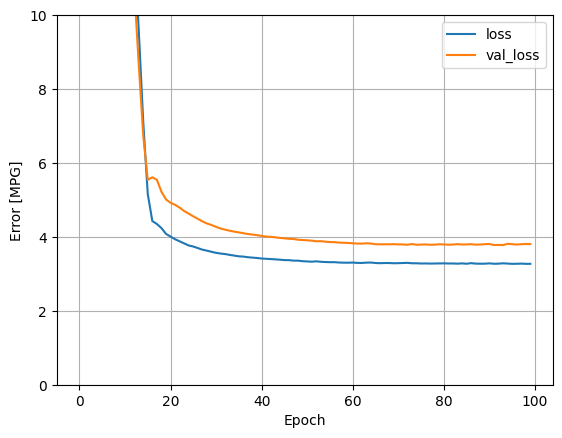

In [74]:
plot_loss(history)

In [75]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

8/8 [==============================] - 0s 2ms/step


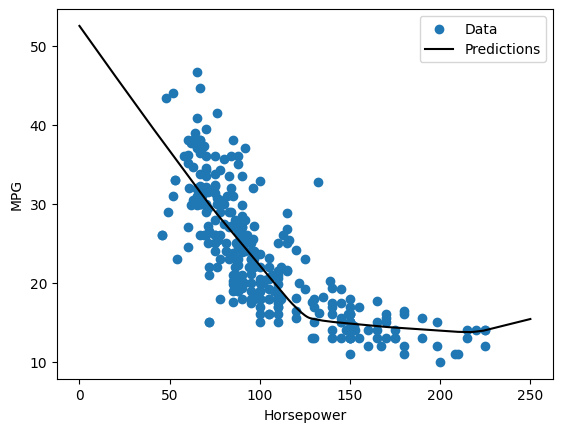

In [76]:
plot_horsepower(x, y)

In [77]:
# Collect the test results for later

test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0
)

#Regression using a DNN and multiple inputs
Repeat the previous process using all the inputs. The model's performance slightly improves on the validation dataset.

In [78]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 9)                19        
 ion)                                                            
                                                                 
 dense_5 (Dense)             (None, 64)                640       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [79]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100
)

CPU times: user 6.3 s, sys: 173 ms, total: 6.47 s
Wall time: 7.18 s


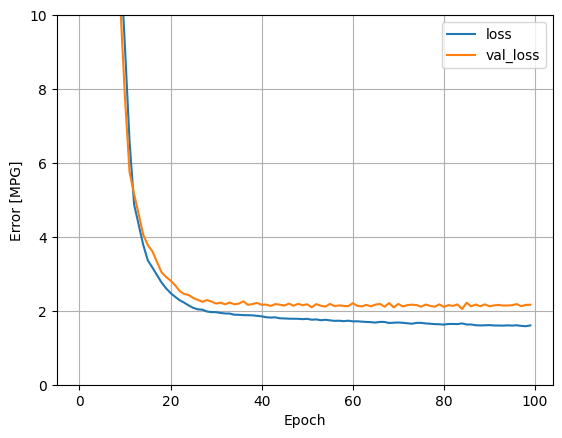

In [80]:
plot_loss(history)

In [81]:
# Collect the test results for later

test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

##Performance
Since all models have been trained, you can review their test set performance:

In [82]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
Horsepower_model,3.635586
linear_model,2.548606
dnn_horsepower_model,2.913985
dnn_model,1.713514


##Make predictions
You can now make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss:

3/3 [==============================] - 0s 6ms/step


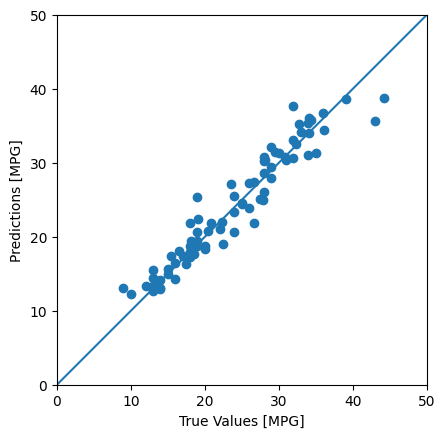

In [83]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

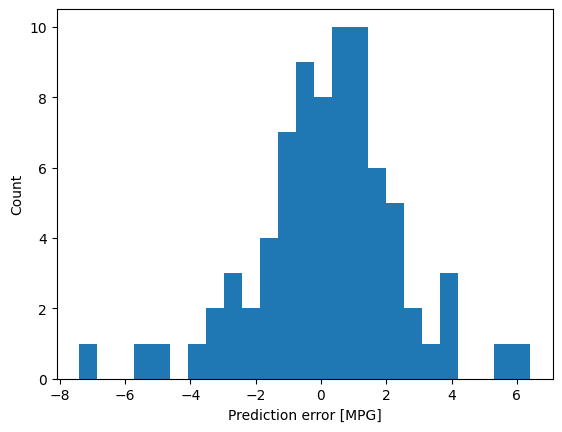

In [84]:
# Checking the error distribution

error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction error [MPG]')
_ = plt.ylabel('Count')

##Save the model

In [86]:
dnn_model.save('dnn_model_MPG')

In [87]:
# Reload the model to se if it still works

reloaded = tf.keras.models.load_model('dnn_model_MPG')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0
)

In [88]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
Horsepower_model,3.635586
linear_model,2.548606
dnn_horsepower_model,2.913985
dnn_model,1.713514
reloaded,1.713514
